# Excercise 7
Give a suitable function, terminal set and s-expression for the following logical and mathematical formulas.

## 7.A. $(Y \land True) \rightarrow ((X \lor Y) \lor (Z \leftrightarrow (X \land Y))) $
### 7.A.1. Function 
$\{\lor, \rightarrow, \land, \leftrightarrow \} $
### 7.A.2. Terminal set
$ \{ Y, True, X, Z \}$
### 7.A.3. S-Expression
$ (\rightarrow\ (\land\ Y\ True)\ ( \lor\ (\lor\ (\ X\ Y\ ) \ (\leftrightarrow\ Z\ (\land\ X\ Y\ ))))$

## 7.B. $ 0.234 * Z + X - 0.789 $
### 7.B.1. Function 
$ \{ *, +, - \}$
### 7.B.2. Terminal set
$ \{ Z, X, 0.234, 0,789\} $
### 7.B.3. S-Expression
$( +\ (*\ 0.234\ Z\ )\ (-\ X\ 0.789)) $


# Excercise 8
Implement a GP program for finding a symbolic expression that fits the following data:                           

|(Input) DependentVariable  | Y(Output) |
| ------------------------- | ----------|
| −1.0                      | 0.0000    |
| −0.9                      | −0.1629   |
| −0.8                      | −0.2624   | 
| −0.7                      | −0.3129   |
| −0.6                      | −0.3264   |
| −0.5                      | −0.3125   |
| −0.4                      | −0.2784   |
| −0.3                      | −0.2289   |
| −0.2                      | −0.1664   |
| −0.1                      | −0.0909   |
|  0                        |    0.0    |
|  0.1                      |  0.1111   |
|  0.2                      |   0.2496  |
|  0.3                      |   0.4251  |
|  0.4                      |   0.6496  |
|  0.5                      |   0.9375  |
|  0.6                      |   1.3056  |
|  0.7                      |   1.7731  |
|  0.8                      |   2.3616  |
|  0.9                      |   3.0951  |
|  1.0                      |   4.0000  |

With the following parameter settings:   
- population size: 1000, 
- function set: {+, −, ∗, log, exp, sin, cos, div}, 
- terminal set: x, 
- number of generations 50, 
- crossover probability 0.7, 
- mutation probability: 0, 
- fitness: - sum of absolute errors

You can use an existing GP framework:   
see for instance list of implementation frameworks mentioned in the syllabus. 
Plot the following:
- (a) best of generation fitness (y-axis) versus generation (x-axis). 
- (b) best of generation size (y-axis) versus generation (x-axis). 

Can you observe any undesirable phenomenon from these plots? In case of positive answer, how would you try to overcome the related problem (you can refer to the literature).



In [1]:
#This solution has been based on code from: https://deap.readthedocs.io/en/master/examples/gp_symbreg.html

import deap.gp as gp
from deap import creator 
from deap import base
from deap import creator
from deap import tools
import numpy as np
import operator
import math
import random
import deap.algorithms as algorithms

data =[[-1.0, 0.0000],[-0.9, -0.1629],[-0.8, -0.2624],[-0.7, -0.3129],[-0.6, -0.3264],[-0.5, -0.3125],[-0.4, -0.2784],
        [-0.3, -0.2289], [-0.2, -0.1664],[-0.1, -0.0909],[0, 0.0],[0.1, 0.1111],[0.2, 0.2496],[0.3, 0.4251],[0.4, 0.6496],
        [0.5, 0.9375], [0.6, 1.3056],[0.7, 1.7731],[0.8, 2.3616],[0.9, 3.0951],[1.0, 4.0000]]

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def protectedLog(base):
    try: 
        return math.log(base)
    except ValueError:
        return 1
    

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.exp, 1)
pset.addPrimitive(protectedLog, 1)
pset.addEphemeralConstant("A", lambda: random.randint(-1,1))


pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # our custom absolute error function
    abserrors = (np.abs(func(x[0]) - x[1]) for x in points)
    #print(points)
    return math.fsum(abserrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=data)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)
    
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1) 
pop, log = algorithms.eaSimple(pop, toolbox, 0.7, 0, 50, stats=mstats,
                                       halloffame=hof, verbose=True)



#plot min fitness (a) 
#plot min size (b)


   	      	                        fitness                         	                      size                     
   	      	--------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std     	avg 	gen	max	min	nevals	std    
0  	100   	1.09632	0  	3.26088	0.442563	100   	0.493144	3.33	0  	7  	2  	100   	1.25742
1  	62    	0.905687	1  	3.64902	0.442563	62    	0.415036	3.25	1  	7  	2  	62    	1.08972
2  	76    	0.819868	2  	2.60793	0.259679	76    	0.343079	3.22	2  	6  	2  	76    	0.954777
3  	68    	0.709892	3  	2.2683 	0.259679	68    	0.246304	3.27	3  	6  	2  	68    	1.18199 
4  	68    	0.67634 	4  	1.60793	0.259679	68    	0.242736	3.63	4  	7  	2  	68    	1.30119 
5  	62    	0.690111	5  	2.86353	0.259679	62    	0.404785	4.12	5  	7  	2  	62    	1.49853 
6  	68    	0.682547	6  	3.05595	0.202237	68    	0.476269	4.83	6  	7  	2  	68    	1.23333 
7  	68    	0.75228 	7  	3.40297	0.202237	68    	0.663

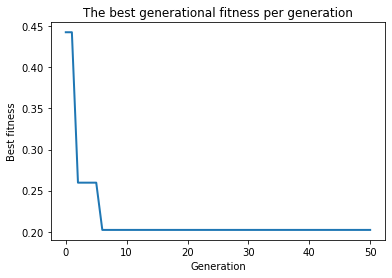

In [2]:
import matplotlib.pyplot as plt

plt.title("The best generational fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.plot(log.select("gen"), log.chapters["fitness"].select("min"), linewidth=2.0)

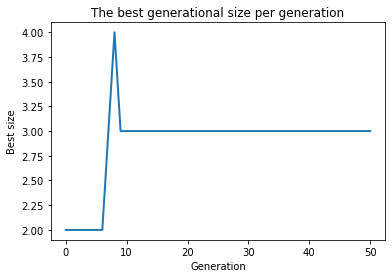

In [3]:
plt.title("The best generational size per generation")
plt.xlabel("Generation")
plt.ylabel("Best size")
plt.plot(log.select("gen"), log.chapters["size"].select("min"), linewidth=2.0)

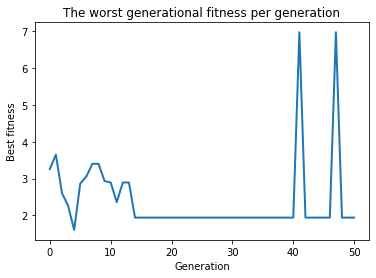

In [4]:
plt.title("The worst generational fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.plot(log.select("gen"), log.chapters["fitness"].select("max"), linewidth=2.0)

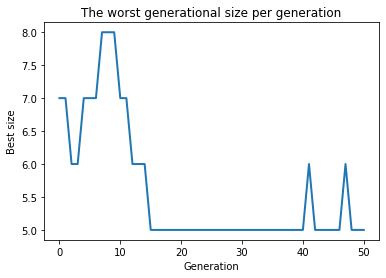

In [5]:
plt.title("The worst generational size per generation")
plt.xlabel("Generation")
plt.ylabel("Best size")
plt.plot(log.select("gen"), log.chapters["size"].select("max"), linewidth=2.0)

#### Can you observe any undesirable phenomenon from these plots? 
The model converges in one generation, and then does not converge any further.
#### In case of positive answer, how would you try to overcome the related problem (you can refer to the literature)
By making use of mutations, where a subtree is replaced by a new randomly generated tree, we can get the network out of a local minimum for better convergence. 